## Exercise 9.1

In [37]:
from __future__ import print_function, division

import first
import hypothesis
import scatter
import thinkstats2
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

import numpy as np

In [2]:
# tests provided by chapter 9
def tests(live, iters=1000):

    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = hypothesis.CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # chi-squared
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))


In [7]:
thinkstats2.RandomSeed(18)

live, firsts, others = first.MakeFrames()

n = len(live)
#running the test 4 times at a third of the size each time
for _ in range(4):
    sample = thinkstats2.SampleRows(live, n)
    tests(sample)
    n = int(n / 3)

9148	0.16	0.00	0.00	0.00
3049	0.26	0.04	0.02	0.00
1016	0.47	0.15	0.03	0.01
338	0.91	0.09	0.53	0.01


In conclusion, the smaller the ammount of data we use the worse the tests reult in being. 

## Exercise 10.1

In [12]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

#importing data and reading heights and weights
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights = df.htm3
weights = df.wtkg2
log_weights = np.log10(weights)

In [13]:
#finding the y intercept and the slope

inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918145, 0.0052814541694177946)

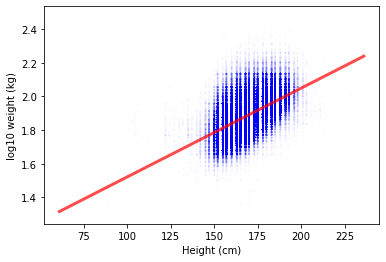

In [15]:
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
x, y = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(x, y, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

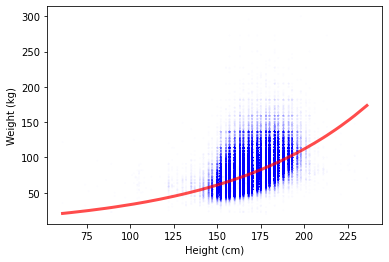

In [16]:
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
x, y = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(x, 10**y, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

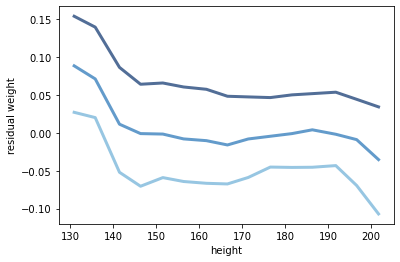

In [17]:
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height', ylabel='residual weight', legend=False)

In [20]:
#calculating correlation
cor = thinkstats2.Corr(heights, log_weights)
print(cor)

#calculating coeffiient of determination

cd = thinkstats2.CoefDetermination(log_weights, res)
print(cd)

0.5317282605983439
0.282734943118939


In [21]:
cor**2 - cd

1.3322676295501878e-15

In [22]:
std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004888

In [23]:
std_res = thinkstats2.Std(res)
std_res

0.0874077708041609

{'xscale': 'linear', 'yscale': 'linear'}

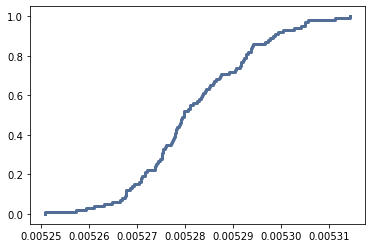

In [25]:
#Resampling 
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [26]:
pvalue = cdf[0]
print("pvalue: ", pvalue)

ci = cdf.Percentile(5), cdf.Percentile(95)
print("ci: ",ci)

mean = thinkstats2.Mean(slopes)
print("Mean: ",mean)

stderr = thinkstats2.Std(slopes)
print("std error:" ,stderr)

pvalue:  0
ci:  (0.005263214894872871, 0.005304218004776975)
Mean:  0.005281942626635877
std error: 1.2135826043020171e-05


In [40]:
#functions provided by book's code
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
    
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [38]:
estimates = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates)

mean, SE, CI 168.95660128539382 0.016378454901900968 (168.92548101214658, 168.98408668323935)


In [41]:
estimates2 = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates2)

mean, SE, CI 170.4967041573193 0.017462624696734257 (170.46772620707776, 170.52940641484267)


The estimated mean is off by a couple of cenimeters. This difference is much larger than the sampling error. 